# Speeding up loading a dataset with the intake

This Tutorial covers speeding up dataset loading with the intake catalog. It covers:
1. Chunking.
2. Combining coordinates
3. Dask Graphs

Slides with an abridged version of the information in this tutorial can be found over at a [post in the ACCESS-Hive forum](https://forum.access-hive.org.au/t/7th-march-2025-introduction-to-cosima-cookbook-cosima-recipes-how-to-make-it-go-loading-data-fast/4263/1).

**Note 1**: Needs a large (or larger) ARE instance. If run using a smaller ARE instance, some things may not work due to lack of computational resources.

**Note 2**: Changing ARE instance size will also affect timings - although changes in speedup/timings should be proportionate to the resources used.

**Note 3**: Depending on the version of the catalog you are using, you may get different warnings. These warning should not affect execution, but may fill up your output, and make the notebook look quite different when you execute it.

___

Because we'll be dealing with chunking, we'll also be using the `validate_chunkspec` tool from `access_intake_utils` - this will let us quickly and easily check that our chunks shouldn't degrade performance. 

In [1]:
import intake # For the catalog
import dask
from dask.distributed import Client # Dask client config
import datetime # We'll use this to time some slow operations
from access_intake_utils.chunking import validate_chunkspec
catalog = intake.cat.access_nri
catalog

In [2]:
client = Client(threads_per_worker = 1)
client
# Open up the dashboard by clicking the launch button below - it'll help you to see what dask is doing when it runs expensive operations. 
# Knowing that Dask is doing something - even if it's slow - can sometimes be worth more than speeding an operation up. 
# You're less likely to cancel it if you don't think it's broken!

<Client: 'tcp://127.0.0.1:33041' processes=7 threads=7, memory=32.00 GiB>

In [3]:
datastore = catalog['01deg_jra55v13_ryf9091'].search(frequency='1mon',variable='u')
datastore

In [5]:
%%timeit -n 3 -r 3
# This should take a couple of minutes to run on a large ARE instance - but be careful, without the -n and -r flags, it can 
# blow out extremely quickly, as %%timeit calls code repeatedly to get an estimate of the runtime.
datastore.to_dask(xarray_open_kwargs = {'decode_timedelta' : False}) # We need to set `xarray_open_kwargs = {'decode_timedelta' : False}` to avoid
# a bunch of annoying warnings. When the next version of intake-esm is released, it won't be necessary any more as the default will change.

17.1 s ± 145 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [4]:
ds = datastore.to_dask(xarray_open_kwargs = {'decode_timedelta' : False}) 

ds['u']

<xarray.DataArray 'u' (time: 2760, st_ocean: 75, yu_ocean: 2700, xu_ocean: 3600)> Size: 8TB
dask.array<concatenate, shape=(2760, 75, 2700, 3600), dtype=float32, chunksize=(1, 7, 300, 400), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 22kB 1950-01-16 12:00:00 ... 2179-12-16 12:00:00
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 22kB -81.09 -81.05 -81.0 ... 89.92 89.96 90.0
Attributes:
    long_name:      i-current
    units:          m/sec
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_x_velocity

___
# Part 1: Chunking

## This is a pretty big dataset, but it would be nice if we could open it in less than 17-18 seconds. Lets see if we can do better.

- Step 1: Inspecting chunking.

__Chunking__

Chunking is core to how Dask, and by extension Xarray work. If we choose good chunks, we can often reduce the amount of work needed to do load an array.

Further Reading: 
- [Xarray Documentation](https://docs.xarray.dev/en/stable/user-guide/dask.html#dask-chunks)
- [Choosing good chunk sizes in Dask](https://blog.dask.org/2021/11/02/choosing-dask-chunk-sizes?utm_source=xarray-docs)


In [5]:
ds['u']

<xarray.DataArray 'u' (time: 2760, st_ocean: 75, yu_ocean: 2700, xu_ocean: 3600)> Size: 8TB
dask.array<concatenate, shape=(2760, 75, 2700, 3600), dtype=float32, chunksize=(1, 7, 300, 400), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 22kB 1950-01-16 12:00:00 ... 2179-12-16 12:00:00
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 22kB -81.09 -81.05 -81.0 ... 89.92 89.96 90.0
Attributes:
    long_name:      i-current
    units:          m/sec
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_x_velocity

___
### We can see from the output above that we have _lots_ (2459160) chunks, each of which are _very_ small (3.20 MiB).
### What this means is that when we do our computations, dask is almost certainly going to be spending lots of time concatenating very small chunks together, for no good reason.
**As a rule of thumb, chunks of ~300MiB are a good starting place. So what happens if we tell dask to make each file into a single chunk?**

- Since our xarray dataarray is 7.32TiB in total, and we have ~32GiB available, there is no way we can load the datasets without chunks.
- However, our dataarray is probably stored over a number of files. As a first pass, lets check how our dataset is structured on disk, and then try to load each file into a single chunk.
- We can see above we have 2760 timestamps. If we look at our dataset again, we see that it has 920 files - so one file for every 3 timestamps. This probably means we have 4 files per year of model output.

___ 

### How can we tell dask to load a single chunk per file?

[`xr.open_dataset`](https://docs.xarray.dev/en/stable/generated/xarray.open_dataset.html) has a `chunks` argument, which lets us tell dask what chunking scheme to use for loading files.
`intake-esm` lets us access this with `xaray_open_kwargs`

- In this instance, we want to specify chunks *on a dimension by dimension basis* - so we'll need the dimension names.


In [8]:
ds['u'].dims

('time', 'st_ocean', 'yu_ocean', 'xu_ocean')

As an easy benchmark, lets time how long it takes us to get a single mean value over all spatial dimensions, selecting the first time time step (this is just to make things manageable - if you're really patient, you could do the full dataset). This will force xarray to do a lot with our chunks - so we'll get a good understanding of how they affect things. If we just open the dataset, they're less important (although we will still see some effects).

In [6]:
ds = datastore.to_dask(xarray_open_kwargs = {'decode_timedelta' : False})
ds.isel(time=0).mean().compute()

<xarray.Dataset> Size: 12B
Dimensions:  ()
Coordinates:
    time     object 8B 1950-01-16 12:00:00
Data variables:
    u        float32 4B 0.007727

In [7]:
%%timeit -n 3 -r 3
# This should take a couple of minutes to run on a large ARE instance - but be careful, without the -n and -r flags, it can 
# blow out extremely quickly, as %%timeit calls code repeatedly to get an estimate of the runtime.
datastore.to_dask(xarray_open_kwargs = {'decode_timedelta' : False}).isel(time=0).mean().compute()

29.4 s ± 2.34 s per loop (mean ± std. dev. of 3 runs, 3 loops each)


- We know we want one chunk per time slice, and we have 920 files and 2760 time steps, so we must have 3 time steps per file. So we'll specify chunks of 3 for time. Why do we do this?
-  If we specify more chunks than each file contains, we will just get chunks the size of each file. So we could specify 3, 4, or 1000 for our time chunks, and we'll still get 3.

How do we know how to set the chunk size for all the other dimensions, if we want one chunk per file?

It turns out it's not necessary - we can use `-1` to represent 'the entire dimension'. So our chunking dict will look like this:

In [6]:
%%timeit -n 3 -r 3
chunks_dict = {
    'time' : 3,
    'st_ocean' : -1,
    'yu_ocean' : -1,
    'xu_ocean' : -1,
}

datastore.to_dask(xarray_open_kwargs={'chunks' : chunks_dict, 'decode_timedelta' : False})
# This is how long it takes just to open the dataset

14.3 s ± 281 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [10]:
chunks_dict = {
    'time' : 3,
    'st_ocean' : -1,
    'yu_ocean' : -1,
    'xu_ocean' : -1,
}
ds_chunked = datastore.to_dask(xarray_open_kwargs={'chunks' : chunks_dict, 'decode_timedelta' : False})

ds_chunked['u']

<xarray.DataArray 'u' (time: 2760, st_ocean: 75, yu_ocean: 2700, xu_ocean: 3600)> Size: 8TB
dask.array<concatenate, shape=(2760, 75, 2700, 3600), dtype=float32, chunksize=(2, 75, 2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 22kB 1950-01-16 12:00:00 ... 2179-12-16 12:00:00
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 22kB -81.09 -81.05 -81.0 ... 89.92 89.96 90.0
Attributes:
    long_name:      i-current
    units:          m/sec
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_x_velocity

What we did above - with `chunks_dict = {'time' : 3, 'st_ocean' : -1, 'yu_ocean' : -1,'xu_ocean' : -1}` - sped up opening the dataset a bit, from ~18 to ~14 seconds. However, the chunks are so big now that if we tried to calculate the mean, we would crash a large ARE instance - our workers only have about 4GB of memory each, and our chunks are bigger than that. So we need smaller chunks. Lets split up on `xu_ocean` too.

In [7]:
%%timeit 
# Just opening the dataset
chunks_dict = {
    'time' : 3,
    'st_ocean' : -1,
    'yu_ocean' : -1,
    'xu_ocean' : 120,
}

datastore.to_dask(xarray_open_kwargs={'chunks' : chunks_dict, 'decode_timedelta' : False})

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/intake_esm/source.py:82: UserWarning: The specified chunks separate the stored chunks along dimension "xu_ocean" starting at index 120. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/intake_esm/source.py:82: UserWarning: The specified chunks separate the stored chunks along dimension "xu_ocean" starting at index 120. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/intake_esm/source.py:82: UserWarning: The specified chunks separate the stored chunks along dimension "xu_ocean" starting at index 120. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr

13.4 s ± 266 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%%timeit 
# Opening the dataset & computing the mean
chunks_dict = {
    'time' : 3,
    'st_ocean' : -1,
    'yu_ocean' : -1,
    'xu_ocean' : 120,
}

datastore.to_dask(xarray_open_kwargs={'chunks' : chunks_dict, 'decode_timedelta' : False}).isel(time=0).mean().compute()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/intake_esm/source.py:82: UserWarning: The specified chunks separate the stored chunks along dimension "xu_ocean" starting at index 120. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/intake_esm/source.py:82: UserWarning: The specified chunks separate the stored chunks along dimension "xu_ocean" starting at index 120. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/intake_esm/source.py:82: UserWarning: The specified chunks separate the stored chunks along dimension "xu_ocean" starting at index 120. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr

48.1 s ± 891 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Two things to note:
1. We've improved our performance (opening the dataset) by about a third from the default! Not bad.
2. When we compute the mean, our performance has slipped significantly - from 29s to 48s - despite following the ~300MiB chunks rule. This isn't good!
3. We've also got a warning that our chunks could degrade performance! What's gone wrong?
# Disk Chunks - A huge (and badly documented) stumbling block

`xarray` lets us specify chunks when we load a dataset. However, there is another kind of chunk we need to contend with: __disk chunks__.

- netCDF files are actually chunked on disk - and if we don't pick chunks that respect those, it can massively slow things down.
- What does 'picking chunks that respect disk chunks' mean? *We need to pick our chunks to be integer multiples of the disk chunks*. If we don't, then we have to open each disk chunk multiple times in order to load the dataset. This can really degrade performance - as shown above - and it's why xarray gave us that warning.

Unfortunately, xarray doesn't make easy to validate that we chose to open our dataset with respect the disk chunking (without trying & waiting for warnings), so we've built a tool to help.

__NOTE__: `access_intake_utils` is only available in the `conda/analysis3-25.05` or later environments.

__Credit__: `access_intake_utils` was forked from [ACDtools](https://github.com/Thomas-Moore-Creative/ACDtools) & builds on the tooling there. 

In [11]:
from access_intake_utils.chunking import validate_chunkspec

# In a Jupyter Notebook, $FUNCTION_NAME? will show you it's signature & documentation
validate_chunkspec?

Signature:
validate_chunkspec(
    dataset: str | pathlib.Path | collections.abc.Iterable[str | pathlib.Path] | xarray.core.dataset.Dataset | xarray.core.dataarray.DataArray | intake_esm.core.esm_datastore,
    chunkspec: dict[str, typing.Any],
    varnames: str | list[str] | None = None,
    validate_mode: Literal['single', 'bookend', 'sample', 'all'] = 'single',
    sample_size: int = 10,
) -> dict | dict[pathlib.Path, dict]
Docstring:
Validate the chunk sizes for a given variable name.


This function attempts to validate that user specified chunks are compatible
with chunking on disk, by ensuring that chunk sizes are integer multiples of
the chunk sizes on disk.

Parameters
----------
dataset: str | Path | Iterable[str | Path] | Dataset | DataArray | esm_datastore
    A very general object that can be used to open a single (or many) netCDF
    files.
chunkspec : dict[str, Any]
    The chunk specification dictionary, used to tell xarray how to chunk the data.
varnames : str | list[s

In [12]:
validate_chunkspec(
    datastore,
    chunkspec={
        'time' : 3,
        'st_ocean' : -1,
        'yu_ocean' : -1,
        'xu_ocean' : 120,
    },
    varnames = 'u'
)

/jobfs/140928250.gadi-pbs/ipykernel_361993/2218576072.py:1: ChunkingWarning: Specified chunks are not integer multiples of the disk chunks. Returning suggested chunks as a dictionary.
  validate_chunkspec(


{'time': 3, 'xu_ocean': 400, 'st_ocean': -1, 'yu_ocean': -1}

What does this mean?

- In the above example, we specified chunks over `xu_ocean` of 120 elements, and the whole dimension in the other spatial dimensions. For time, we opened all 3 timesteps in each file as a single chunk.
- This *vastly* reduced the number of chunks - and this is what improved our performance *opening the file*, as we had less communication overhead, and a smaller dask graph to build.
- However, `validate_chunkspec` has shown that we actually didn't read the files in an optimal fashion, as we had to open and read each `xu_ocean` chunk multiple times in order to load the data.
- This is what caused the performance degradation when we tried to compute the mean - we had to open each disk chunk multiple times.

__Takeaway__: Even though we didn't read the chunks in the file optimally, by picking a sensible number of chunks, we've opened the file about a third faster. However, this has come at the (much larger) expense of slowing down subsequent computations a lot.

So what happens if we read the file chunks optimally, too? Luckily, validate chunkspec has returned an optimised chunk specification dictionary - so let's use that.

In [13]:
optimised_chunks = validate_chunkspec(
    datastore,
    chunkspec={
        'time' : 3,
        'st_ocean' : -1,
        'yu_ocean' : -1,
        'xu_ocean' : 120,
    },
    varnames = 'u'
)

/jobfs/140928250.gadi-pbs/ipykernel_361993/95091794.py:1: ChunkingWarning: Specified chunks are not integer multiples of the disk chunks. Returning suggested chunks as a dictionary.
  optimised_chunks = validate_chunkspec(


In [6]:
%%timeit -n 3 -r 3
datastore.to_dask(xarray_open_kwargs={'chunks' : optimised_chunks, 'decode_timedelta' : False})
# Just opening the dataset, it's similar to before.

15.3 s ± 1.94 s per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [14]:
%%timeit -n 3 -r 3
# Opening the dataset & computing the mean
datastore.to_dask(xarray_open_kwargs={'chunks' : optimised_chunks, 'decode_timedelta' : False}).isel(time=0).mean().compute()

28.7 s ± 453 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


## So even with optimised chunks that are about the right size, we still didn't really improve things a great deal.

#### Sometimes, getting the chunks right can be more of an art than a science.

- We tried to follow the 300MiB chunk rule of thumb above, and slowed down loading our dataset by 50% - so the warnings about degrading performance were right. This is because the chunks we chose weren't integer multiples of the disk chunks. However, without `validate_chunkspec`, we would have had no (easy) way of knowing this!
- If we wanted to throw away a large fraction of a dimension - for example, if we were only interested in data in the Southern Ocean, we could instead have tried to split our chunks up on latitude. That way, when we select a subset of data, we can throw away a lot of chunks - without having to extract a subset of their data first.

- You can also try `'chunks' : 'auto'` to let xarray decide - there's also a chance this will speed things up. It should respect the disk chunking - but occasionally doesn't


In [9]:
datastore.to_dask(xarray_open_kwargs={'chunks' : 'auto', 'decode_timedelta' : False})['u']

<xarray.DataArray 'u' (time: 2760, st_ocean: 75, yu_ocean: 2700, xu_ocean: 3600)> Size: 8TB
dask.array<concatenate, shape=(2760, 75, 2700, 3600), dtype=float32, chunksize=(2, 14, 600, 800), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 22kB 1950-01-16 12:00:00 ... 2179-12-16 12:00:00
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 22kB -81.09 -81.05 -81.0 ... 89.92 89.96 90.0
Attributes:
    long_name:      i-current
    units:          m/sec
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_x_velocity

In [15]:
%%timeit -n 3 -r 3
mean_chunks = datastore.to_dask(xarray_open_kwargs={'chunks' : 'auto', 'decode_timedelta' : False}).isel(time=0).mean().compute()

23.9 s ± 115 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [10]:
# Note the chunks that 'auto' gives us - what hapens if we manually specify those?
ds = datastore.to_dask(xarray_open_kwargs=
    {'chunks' :{
        'time' : 2,
        'st_ocean' : 14,
        'yu_ocean' : 600,
        'xu_ocean' : 800,
    },
'decode_timedelta' : False})

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/intake_esm/source.py:82: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 2. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/intake_esm/source.py:82: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 2. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/intake_esm/source.py:82: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 2. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(url,

When we look at the two cells above & the cell below, we see that we have the exact same chunks, and the exact same dask graph as we would if we specified `'chunks' : 'auto'`. 
However, we now have a bucketload of warnings. This is because the chunks dask chose are not integer multiples of the disk chunks over time. In this instance, it doesn't matter - we're only selecting the first time anyway - but it's worth being aware of. `'chunks' : 'auto'` *should* choose integer multiples of the disk chunks, but it didn't quite work here. We'll explore why after the exercises below.


In [7]:
ds['u']

<xarray.DataArray 'u' (time: 2760, st_ocean: 75, yu_ocean: 2700, xu_ocean: 3600)> Size: 8TB
dask.array<concatenate, shape=(2760, 75, 2700, 3600), dtype=float32, chunksize=(2, 14, 600, 800), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 22kB 1950-01-16 12:00:00 ... 2179-12-16 12:00:00
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 22kB -81.09 -81.05 -81.0 ... 89.92 89.96 90.0
Attributes:
    long_name:      i-current
    units:          m/sec
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_x_velocity

# Can you improve on what we've done here? Things to try:
1. Select the data we want to open at the datastore stage, not after opening the dataset.
2. Play around with chunking. What's the best you can do? For more info on chunking, see [here](https://docs.xarray.dev/en/stable/generated/xarray.open_dataset.html#xarray-open-dataset) and [here](https://docs.dask.org/en/latest/array-chunks.html). If you can beat 24 seconds, open a pull request and let us know!
3. What about rechunking after you load the dataset? See [here](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.chunk.html)

In [ ]:
# Exercise 1.
%%timeit
datastore.search(...).to_dask(xarray_open_kwargs={'chunks' : 'auto', 'decode_timedelta' : False}).isel(time=0).mean(dim=['st_ocean','yu_ocean','xu_ocean']).compute()

In [ ]:
# Exercise 2.
%%timeit
datastore.to_dask(xarray_open_kwargs={'chunks' : ... 'decode_timedelta' : False}).isel(time=0).mean(dim=['st_ocean','yu_ocean','xu_ocean']).compute()

In [ ]:
# Exercise 3.
%%timeit
ds = datastore.to_dask(xarray_open_kwargs={'decode_timedelta' : False, 'chunks' : ...})
ds.chunk(...).isel(time=0).mean(dim=['st_ocean','yu_ocean','xu_ocean']).compute()

## Some extra notes on disk chunks & using `validate_chunkspec` to avoid slowing things down

In [16]:
# Let's try validating our the chunks provided by `'chunks' : 'auto'` from earlier - are they optimal?

validate_chunkspec(datastore, chunkspec={
        'time' : 2,
        'st_ocean' : 14,
        'yu_ocean' : 600,
        'xu_ocean' : 800,
    },
    varnames = 'u'
)

{'time': 2, 'st_ocean': 14, 'yu_ocean': 600, 'xu_ocean': 800}

### Xarray's automatically determined chunks should be optimal in the sense that they don't read disk chunks multiple times. 

This can also be validated with ncdump, if we use the -hs flags. So why did we get those warnings?

In [19]:
fname = datastore.df.path.head(1).tolist()[0]
print(f"{fname=}")

fname='/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output1000/ocean/ocean.nc'


In [20]:
!ncdump -hs /g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output1000/ocean/ocean.nc

netcdf ocean {
dimensions:
	xt_ocean = 3600 ;
	yt_ocean = 2700 ;
	st_ocean = 75 ;
	st_edges_ocean = 76 ;
	time = UNLIMITED ; // (3 currently)
	nv = 2 ;
	xu_ocean = 3600 ;
	yu_ocean = 2700 ;
	sw_ocean = 75 ;
	sw_edges_ocean = 76 ;
	grid_xu_ocean = 3600 ;
	grid_yt_ocean = 2700 ;
	potrho = 80 ;
	potrho_edges = 81 ;
	grid_xt_ocean = 3600 ;
	grid_yu_ocean = 2700 ;
	neutral = 80 ;
	neutralrho_edges = 81 ;
variables:
	double xt_ocean(xt_ocean) ;
		xt_ocean:long_name = "tcell longitude" ;
		xt_ocean:units = "degrees_E" ;
		xt_ocean:cartesian_axis = "X" ;
		xt_ocean:_Storage = "chunked" ;
		xt_ocean:_ChunkSizes = 3600 ;
		xt_ocean:_Shuffle = "true" ;
		xt_ocean:_DeflateLevel = 5 ;
		xt_ocean:_Endianness = "little" ;
		xt_ocean:_NoFill = "true" ;
	double yt_ocean(yt_ocean) ;
		yt_ocean:long_name = "tcell latitude" ;
		yt_ocean:units = "degrees_N" ;
		yt_ocean:cartesian_axis = "Y" ;
		yt_ocean:_Storage = "chunked" ;
		yt_ocean:_ChunkSizes = 2700 ;
		yt_ocean:_Shuffle = "true" ;
		yt_ocean:_Deflat

- So `u` has disk chunks `{'time' : 1, 'st_ocean' : 7, 'yu_ocean' : 300,'xu_ocean' : 400}`
- Note that different variables have different chunking - if we don't specify the variable we want to know the chunking of in `validate_chunkspec`, we might get a wrong answer!
- When we ask for just 'u' above, we also load all `xu_ocean`, `yu_ocean`, `st_ocean` and `time` - let's add those variables in and see if our chunking is optimal for those too (spoiler - it isn't).

This is why the chunk specification dictionary that we got from `'chunks' : 'auto'` caused all those warnings - because different variables in a dataset can be chunked differently!

In [24]:
validate_chunkspec(datastore, chunkspec={
        'time' : 2,
        'st_ocean' : 14,
        'yu_ocean' : 600,
        'xu_ocean' : 800,
    },
    varnames = ['u', 'xu_ocean', 'yu_ocean', 'st_ocean', 'time']
)

/jobfs/140536494.gadi-pbs/ipykernel_26508/3664508136.py:1: ChunkingWarning: Specified chunks are not integer multiples of the disk chunks. Returning suggested chunks as a dictionary.
  validate_chunkspec(datastore, chunkspec={


{'time': 3, 'st_ocean': 75, 'yu_ocean': 2700, 'xu_ocean': 3600}

#### It turns out our coordinates aren't chunked at all (these are the sizes of the netcdf files).
- Since coordinates are often just 1D arrays, it doesn't make sense to chunk them a lot of the time.
- This example here mostly serves to show how `validate_chunkspec` will suggest (hopefully) better chunks if the chunks you pick aren't optimal.
- Note that the chunking dictionary returned by `validate_chunkspec` is *as close as possible* to the original chunking specification, whilst being an integer multiple of the disk chunks of the variables we're validating. It just happens that in this instance, that's the full file size.

In [25]:
validate_chunkspec(datastore, chunkspec={
        'time' : 2,
        'st_ocean' : 15, # We've now changed our 'st_ocean' chunk to 15: which isn't an integer multiple of the disk chunks
        'yu_ocean' : 600,
        'xu_ocean' : 800,
    },
    varnames = ['u']
)
# In this instance, validate chunkspec tells us to change our chunk in 'st_ocean' from 15 to 14 to speed things up. This takes us back to what 'auto' gave us!

/jobfs/140536494.gadi-pbs/ipykernel_26508/2871408491.py:1: ChunkingWarning: Specified chunks are not integer multiples of the disk chunks. Returning suggested chunks as a dictionary.
  validate_chunkspec(datastore, chunkspec={


{'time': 2, 'st_ocean': 14, 'yu_ocean': 600, 'xu_ocean': 800}

## What about a dataset where chunking isn't really the problem?

In [5]:
datastore = catalog['025deg_era5_ryf'].search(frequency='1mon',file_id='iceh_XXXX_XX',variable='aicen_m')
datastore

In [6]:
# Please don't run this - it can be super slow!
# I've used the datetime module rather than %time or %%timeit as they take even longer!
# However, profiling like this can be very inaccurate: see eg. https://github.com/Kai-Striega/EuroSciPy-2023-Speech/blob/main/EuroSciPy_Speech.pdf
# for a detailed discussion on profiling.
t0 = datetime.datetime.utcnow()
ds = datastore.to_dask()
t1 = datetime.datetime.utcnow()

dt = t1 - t0

print(f"took ~= {dt.seconds // 60} minutes, {dt.seconds % 60 } seconds to load")
ds

took ~= 4 minutes, 13 seconds to load


<xarray.Dataset> Size: 13GB
Dimensions:  (time: 408, nc: 5, nj: 1080, ni: 1440)
Coordinates:
  * time     (time) object 3kB 1900-02-01 00:00:00 ... 1934-01-01 00:00:00
    TLON     (nj, ni) float32 6MB dask.array<chunksize=(540, 720), meta=np.ndarray>
    TLAT     (nj, ni) float32 6MB dask.array<chunksize=(540, 720), meta=np.ndarray>
    ULON     (nj, ni) float32 6MB dask.array<chunksize=(540, 720), meta=np.ndarray>
    ULAT     (nj, ni) float32 6MB dask.array<chunksize=(540, 720), meta=np.ndarray>
    NCAT     (nc) float32 20B dask.array<chunksize=(5,), meta=np.ndarray>
Dimensions without coordinates: nc, nj, ni
Data variables:
    aicen_m  (time, nc, nj, ni) float32 13GB dask.array<chunksize=(1, 1, 540, 720), meta=np.ndarray>
Attributes: (12/19)
    title:                                    sea ice model output for CICE
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   Los Alamos Sea Ice Model (CICE)...
    time_period_freq:                         month_1
    comment:                                  All years have exactly 365 days
    comment3:                                 seconds elapsed into model date...
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,,,,,,,,,,,time: mean,t...
    intake_esm_attrs:variable_units:          days since 1900-01-01 00:00:00,...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   iceh_XXXX_XX.1mon

In [7]:
# Like we did above, lets try to set one chunk per file to speed things up.
t0 = datetime.datetime.utcnow()
ds = datastore.to_dask(xarray_open_kwargs={'chunks' : {'time' :408 , 'nc' : -1, 'ni' : 1440, 'nj' : 1080}})
t1 = datetime.datetime.utcnow()

dt = t1 - t0

print(f"took ~= {dt.seconds // 60} minutes, {dt.seconds % 60 } seconds to load")
ds

took ~= 4 minutes, 55 seconds to load


<xarray.Dataset> Size: 13GB
Dimensions:  (time: 408, nc: 5, nj: 1080, ni: 1440)
Coordinates:
  * time     (time) object 3kB 1900-02-01 00:00:00 ... 1934-01-01 00:00:00
    TLON     (nj, ni) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    TLAT     (nj, ni) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    ULON     (nj, ni) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    ULAT     (nj, ni) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    NCAT     (nc) float32 20B dask.array<chunksize=(5,), meta=np.ndarray>
Dimensions without coordinates: nc, nj, ni
Data variables:
    aicen_m  (time, nc, nj, ni) float32 13GB dask.array<chunksize=(1, 5, 1080, 1440), meta=np.ndarray>
Attributes: (12/19)
    title:                                    sea ice model output for CICE
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   Los Alamos Sea Ice Model (CICE)...
    time_period_freq:                         month_1
    comment:                                  All years have exactly 365 days
    comment3:                                 seconds elapsed into model date...
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,,,,,,,,,,,time: mean,t...
    intake_esm_attrs:variable_units:          days since 1900-01-01 00:00:00,...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   iceh_XXXX_XX.1mon

___
# Part 2: Combining coordinates

### Unfortunately, that didn't seem to help much - it might have even made things a bit slower. 
- So what is the issue?

It turns our that xarray is checking that all our coordinates are consistent. Doing that with the 2D arrays `(ni,nj)` can be really quite slow. Fortunately, we have options to turn these checks off too, if we are confident we don't need them. In this instance, they come from a consistent model grid, so we know we can get rid of them.

#### We don't use `xarray_open_kwargs` for this: we use `xarray_combine_by_kwargs`

Lets see if we can beat four minutes...
___
Step 1: Lets concatenate together the minimal set of variables

In [8]:
t0 = datetime.datetime.utcnow()
datastore.to_dask(
    xarray_combine_by_coords_kwargs={ 
        'data_vars': 'minimal',
        'coords': 'minimal'
    }
)
t1 = datetime.datetime.utcnow()

dt = t1 - t0

print(f"took ~= {dt.seconds // 60} minutes, {dt.seconds % 60 } seconds to load")
ds

took ~= 11 minutes, 16 seconds to load


<xarray.Dataset> Size: 13GB
Dimensions:  (time: 408, nc: 5, nj: 1080, ni: 1440)
Coordinates:
  * time     (time) object 3kB 1900-02-01 00:00:00 ... 1934-01-01 00:00:00
    TLON     (nj, ni) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    TLAT     (nj, ni) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    ULON     (nj, ni) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    ULAT     (nj, ni) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    NCAT     (nc) float32 20B dask.array<chunksize=(5,), meta=np.ndarray>
Dimensions without coordinates: nc, nj, ni
Data variables:
    aicen_m  (time, nc, nj, ni) float32 13GB dask.array<chunksize=(1, 5, 1080, 1440), meta=np.ndarray>
Attributes: (12/19)
    title:                                    sea ice model output for CICE
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   Los Alamos Sea Ice Model (CICE)...
    time_period_freq:                         month_1
    comment:                                  All years have exactly 365 days
    comment3:                                 seconds elapsed into model date...
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,,,,,,,,,,,time: mean,t...
    intake_esm_attrs:variable_units:          days since 1900-01-01 00:00:00,...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   iceh_XXXX_XX.1mon

#### So this actually slowed things down pretty substantially - that's not ideal!

Step 2: Let's set the `compat` flag to `override`. This skips a bunch of checks that slow things down a bunch.
Note however: if we don't set `'datavars' : 'minimal'` and `'coords' : 'minimal'`, this can throw an error.


In [9]:
t0 = datetime.datetime.utcnow()
datastore.to_dask(
    xarray_combine_by_coords_kwargs={ 
        'compat' : 'override',
        'data_vars': 'minimal',
        'coords': 'minimal'
    }
)
t1 = datetime.datetime.utcnow()

dt = t1 - t0

print(f"took ~= {dt.seconds // 60} minutes, {dt.seconds % 60 } seconds to load")
ds

took ~= 0 minutes, 12 seconds to load


<xarray.Dataset> Size: 13GB
Dimensions:  (time: 408, nc: 5, nj: 1080, ni: 1440)
Coordinates:
  * time     (time) object 3kB 1900-02-01 00:00:00 ... 1934-01-01 00:00:00
    TLON     (nj, ni) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    TLAT     (nj, ni) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    ULON     (nj, ni) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    ULAT     (nj, ni) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    NCAT     (nc) float32 20B dask.array<chunksize=(5,), meta=np.ndarray>
Dimensions without coordinates: nc, nj, ni
Data variables:
    aicen_m  (time, nc, nj, ni) float32 13GB dask.array<chunksize=(1, 5, 1080, 1440), meta=np.ndarray>
Attributes: (12/19)
    title:                                    sea ice model output for CICE
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   Los Alamos Sea Ice Model (CICE)...
    time_period_freq:                         month_1
    comment:                                  All years have exactly 365 days
    comment3:                                 seconds elapsed into model date...
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,,,,,,,,,,,time: mean,t...
    intake_esm_attrs:variable_units:          days since 1900-01-01 00:00:00,...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   iceh_XXXX_XX.1mon

## That made a huge difference - we've gone down from 4 minutes to 12 seconds. Can we do better by setting the chunking too now?

In [11]:
%%timeit
# Finally, lets combine it all, and see how fast we can get!

chunks_dict = {
    'time' : 408,
    'nc' : -1,
    'nj' : -1,
    'ni' : -1,
}

datastore.to_dask(
    xarray_open_kwargs={'chunks' : chunks_dict},
    xarray_combine_by_coords_kwargs={ 'compat' : 'override', 'data_vars': 'minimal', 'coords': 'minimal'}
)

10.1 s ± 292 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
chunks_dict = {
    'time' : 408,
    'nc' : -1,
    'nj' : -1,
    'ni' : -1,
}

ds = datastore.to_dask(
    xarray_open_kwargs={'chunks' : chunks_dict},
    xarray_combine_by_coords_kwargs={ 'compat' : 'override', 'data_vars': 'minimal', 'coords': 'minimal'}
)

ds['aicen_m']

<xarray.DataArray 'aicen_m' (time: 408, nc: 5, nj: 1080, ni: 1440)> Size: 13GB
dask.array<concatenate, shape=(408, 5, 1080, 1440), dtype=float32, chunksize=(1, 5, 1080, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 3kB 1900-02-01 00:00:00 ... 1934-01-01 00:00:00
    TLON     (nj, ni) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    TLAT     (nj, ni) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    ULON     (nj, ni) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    ULAT     (nj, ni) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    NCAT     (nc) float32 20B dask.array<chunksize=(5,), meta=np.ndarray>
Dimensions without coordinates: nc, nj, ni
Attributes:
    units:          1
    long_name:      ice area, categories
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

### So, for this dataset, we can go from 4 minutes to ten seconds with some thought - or 4 minutes to 12 seconds using the `xarray_combine_by_coords_kwargs`.

TLDR; 
- If your dataset is taking a long time to load, start by adding `xarray_combine_by_coords_kwargs={ 'compat' : 'override', 'data_vars': 'minimal', 'coords': 'minimal'}` to your `datastore.to_dask()` call.
- Chunking may be able to improve things further - but it might also make it worse. It is more likely to be a source of issues once you start working with, rather than just loading, the data.
- Subsetting to the minimal dataset you want to open, *before* you open it in xarray with `.to_dask()`, will make a massive difference to load times.
- By using `xarray_combine_by_coords_kwargs` and `xarray_open_kwargs`, you can achieve a lot of control over how xarray opens your dataset - see [combine by coords](https://docs.xarray.dev/en/stable/generated/xarray.combine_by_coords.html#xarray.combine_by_coords) and [open dataset](https://docs.xarray.dev/en/stable/generated/xarray.open_dataset.html#xarray-open-dataset) for all the options.
___

## Exercises

Lets go back to our original dataset, and try to efficiently load some data.

1. Lets try loading the daily data for the first year: first by selecting only the data for the first year, and secondly by opening all the data as efficiently as possible. Which works better?
2. Lets plot the average of top grid cell temperature over the whole dataset. Now, can we make it faster using chunks?

In [25]:
catalog

In [ ]:
datastore = catalog['01deg_jra55v13_ryf9091'].search(frequency='1day',variable='u')

In [ ]:
t0 = datetime.datetime.utcnow()

datastore.search(...).to_dask() ### Make changes here

t1 = datetime.datetime.utcnow()

dt = t1 - t0

print(f"took ~= {dt.seconds // 60} minutes, {dt.seconds % 60 } seconds to load")

In [ ]:
t0 = datetime.datetime.utcnow()

datastore.to_dask(...) ### Make changes here

t1 = datetime.datetime.utcnow()

dt = t1 - t0

print(f"took ~= {dt.seconds // 60} minutes, {dt.seconds % 60 } seconds to load")

In [ ]:
datastore = catalog['01deg_jra55v13_ryf9091'].search(variable='temp',frequency='1mon')
datastore

# Now let's use chunking and combining cordinates to try to speed up our plot


# datastore.to_dask(xarray_open_kwargs={'decode_timedelta' : False, 'chunks' :  ...}, xarray_combine_by_kwargs = { ...} ).mean(dim='time').isel(
datastore.to_dask(xarray_open_kwargs={'decode_timedelta' : False})['temp'].mean(dim='time').isel(st_ocean=0).plot()
# ^ This will take forever, but by being clever about how we load the data and using the tricks above, we can make it quite a bit faster.

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 158.24 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


___
# Part 3: Dask Graphs
## Dask Task Graphs

- The `dask_graph` that an xarray dataset contains tells us some information about how data in the dataset is realised - and it can sometimes give us useful information.
- The warning above tells us that we've sent Dask a large task graph. What exactly does this mean?

__Note__: You probably won't want to probe into what this section explores too much - but it can be helpful if you're struggling to work out why a computation is slow


In [4]:
twelve_chunks = datastore.search(
    start_date='1950-01-01, 00:00:00',variable='temp'
).to_dask(
    xarray_open_kwargs={
        'chunks' : {
            'time' : 3,
            'st_ocean' : 75,
            'xt_ocean' : 900,
            'yt_ocean' : 900,
        },
        'decode_timedelta': False
    }
)
twelve_chunks

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/intake_esm/source.py:82: UserWarning: The specified chunks separate the stored chunks along dimension "xt_ocean" starting at index 900. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(url, **xarray_open_kwargs)


<xarray.Dataset> Size: 9GB
Dimensions:   (time: 3, st_ocean: 75, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 24B 1950-01-16 12:00:00 ... 1950-03-16 12:00:00
Data variables:
    temp      (time, st_ocean, yt_ocean, xt_ocean) float32 9GB dask.array<chunksize=(3, 75, 900, 900), meta=np.ndarray>
Attributes: (12/19)
    filename:                                 ocean.nc
    title:                                    ACCESS-OM2-01
    grid_type:                                mosaic
    grid_tile:                                1
    intake_esm_vars:                          ['temp']
    intake_esm_attrs:filename:                ocean.nc
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,sea_water_po...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,,,,,,,,,,time: mean,ti...
    intake_esm_attrs:variable_units:          degrees_E,degrees_N,meters,mete...
    intake_esm_attrs:realm:                   ocean
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   ocean.1mon

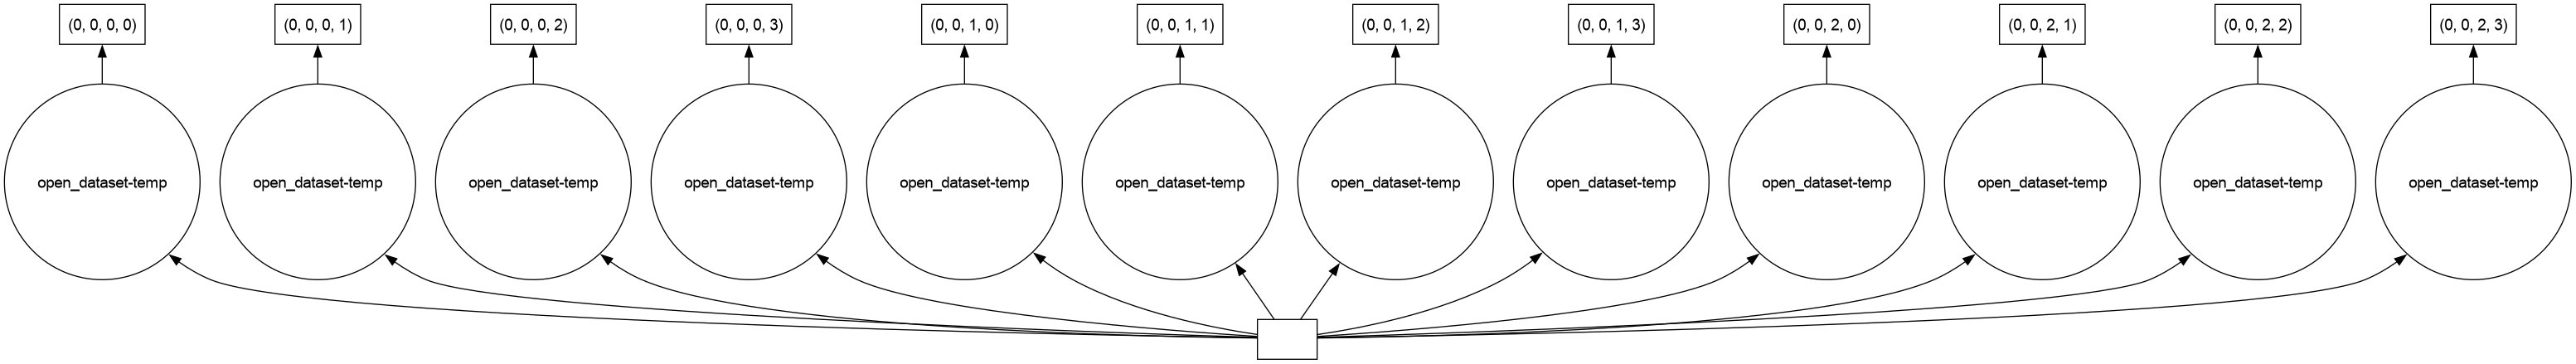

In [10]:
import dask
dask.visualize(twelve_chunks)

In [15]:
three_chunks = datastore.search(
    start_date='1950-01-01, 00:00:00',variable='temp'
).to_dask(
    xarray_open_kwargs={
        'chunks' : {
            'time' : 3,
            'st_ocean' : 75,
            'xt_ocean' : 3600,
            'yt_ocean' : 900,
        },
        'decode_timedelta': False
    }
)
three_chunks

<xarray.Dataset> Size: 9GB
Dimensions:   (time: 3, st_ocean: 75, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 24B 1950-01-16 12:00:00 ... 1950-03-16 12:00:00
Data variables:
    temp      (time, st_ocean, yt_ocean, xt_ocean) float32 9GB dask.array<chunksize=(3, 75, 900, 3600), meta=np.ndarray>
Attributes: (12/19)
    filename:                                 ocean.nc
    title:                                    ACCESS-OM2-01
    grid_type:                                mosaic
    grid_tile:                                1
    intake_esm_vars:                          ['temp']
    intake_esm_attrs:filename:                ocean.nc
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,sea_water_po...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,,,,,,,,,,time: mean,ti...
    intake_esm_attrs:variable_units:          degrees_E,degrees_N,meters,mete...
    intake_esm_attrs:realm:                   ocean
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   ocean.1mon

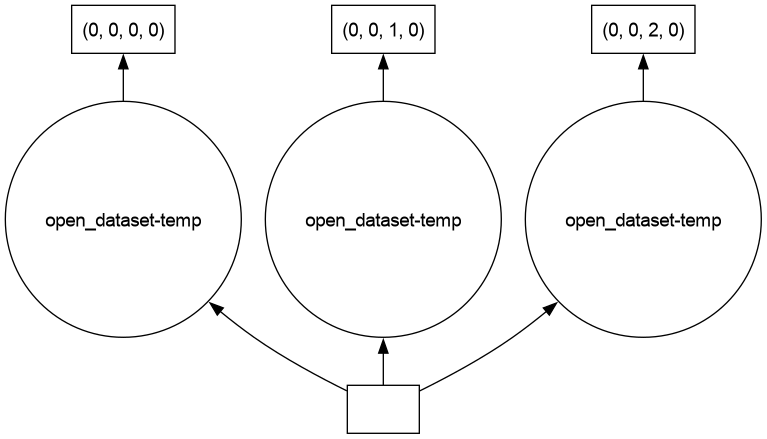

In [16]:
dask.visualize(three_chunks)

## Okay: So what does this actually show?

When we have 12 chunks, Dask opens our dataset, and then splits it out into 12 subsets of the data. Similarly, when we have three, it splits it out into 3 subsets. 

This might seem obvious, but what happens now when we want to combine things back together? Let's look at the mean over the whole dataset

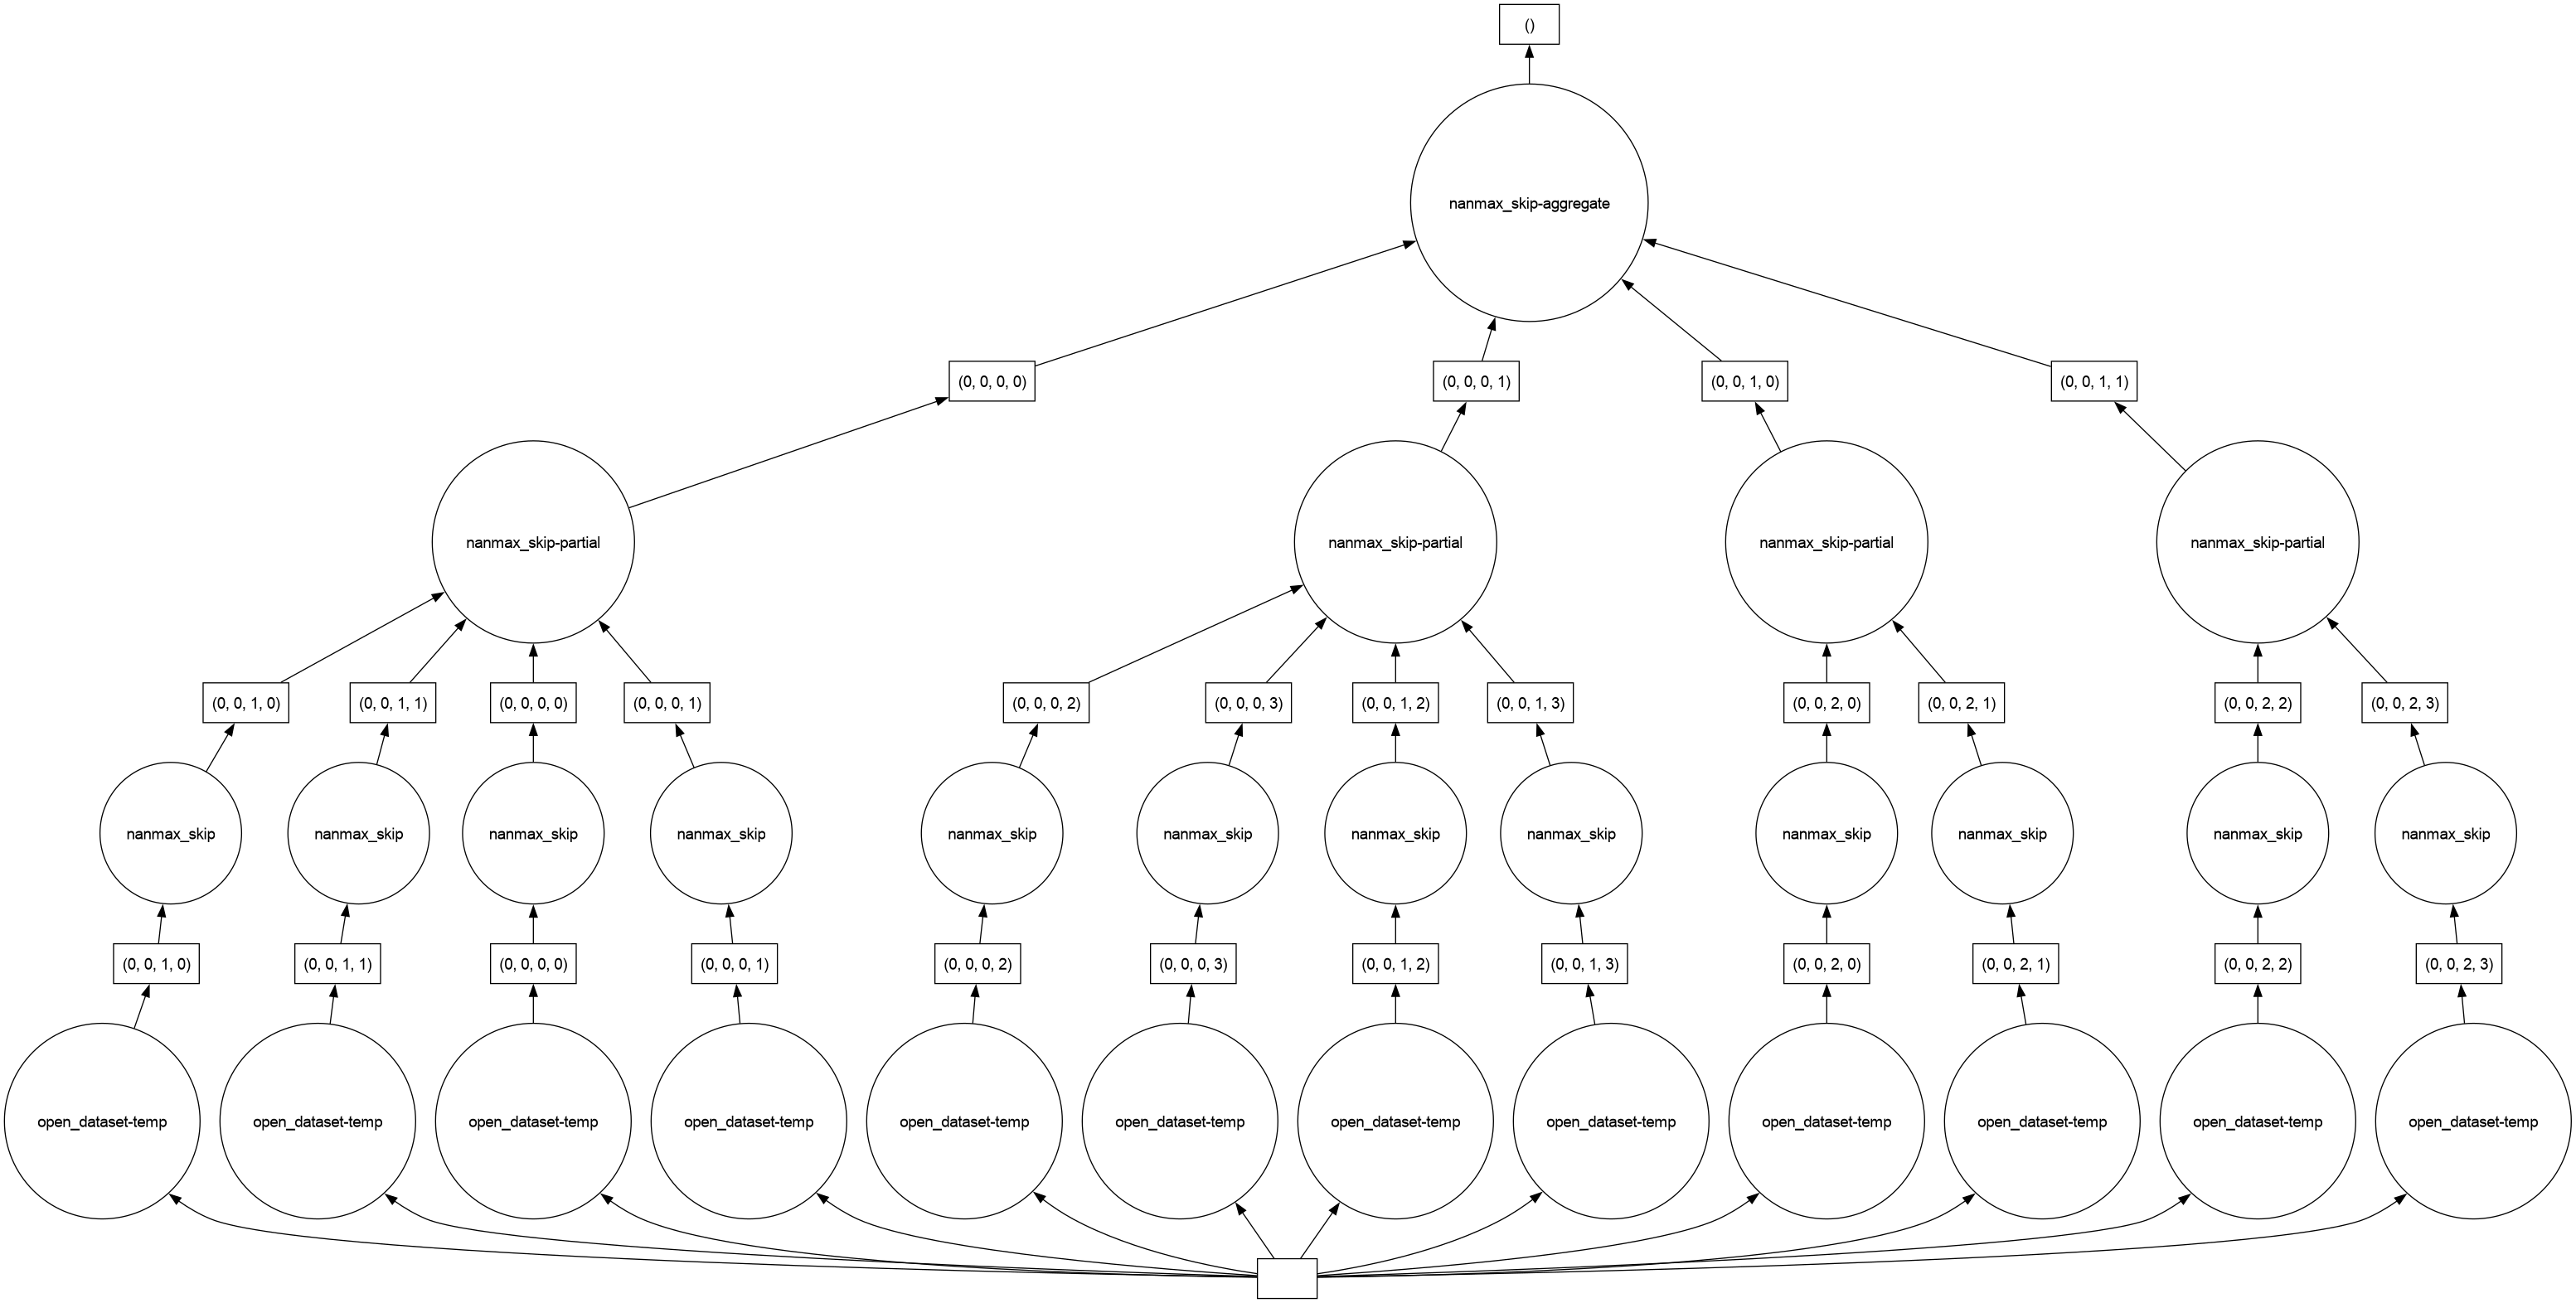

In [28]:
dask.visualize(twelve_chunks.max())

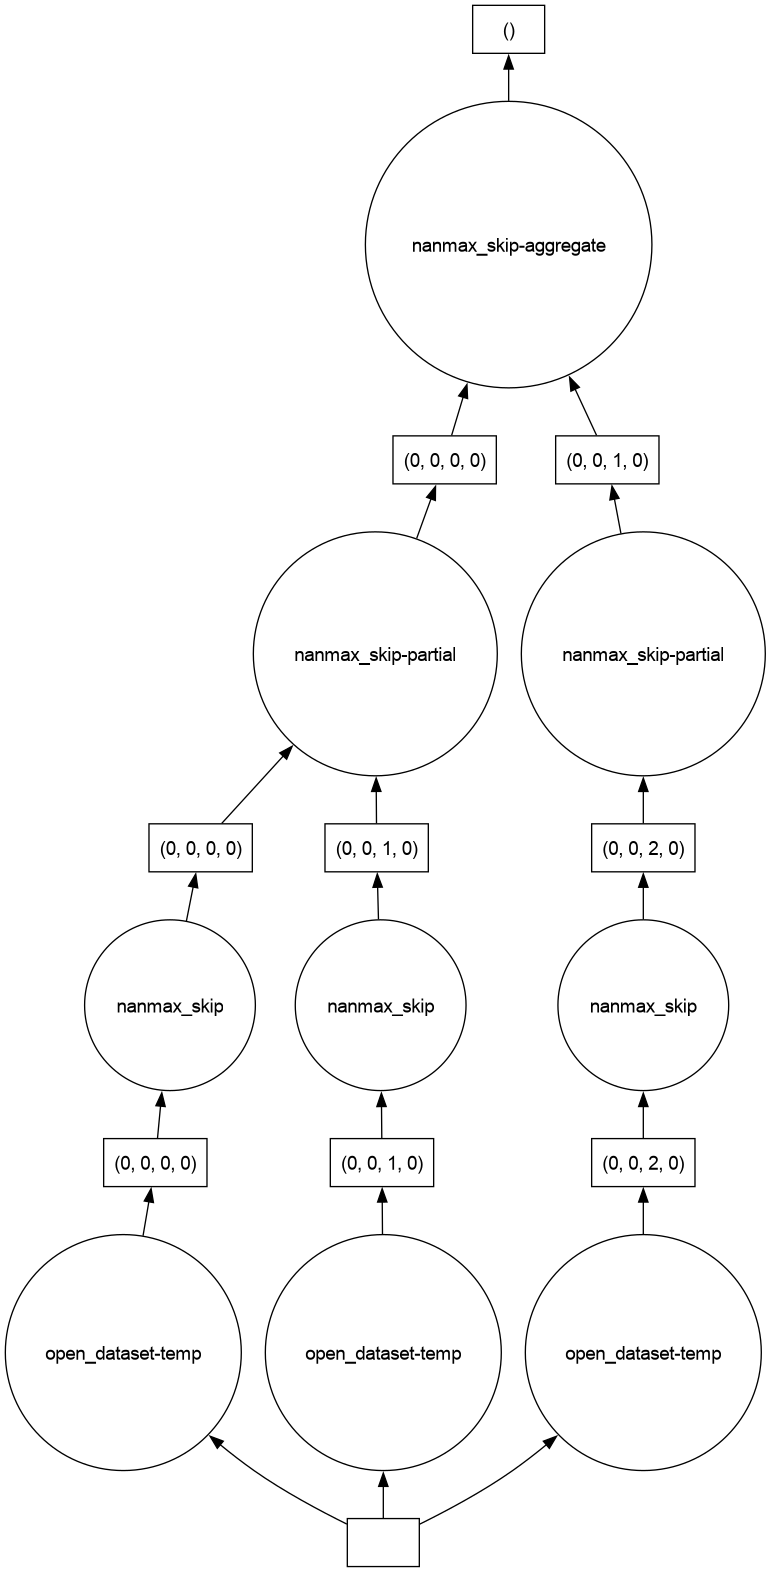

In [27]:
dask.visualize(three_chunks.max())

We can see that as we add more chunks, the task graph gets bigger (__very quickly__). This can be a potential source of issues - if you've chunked badly, then dask has to do a lot of operations to put the dataset back together. For example, if you pick miniscule chunks, a large part of the computation time will be dask stitching the chunks back together. Let's demonstrate that:


In [30]:
%%timeit
twelve_chunks.max()

2.5 ms ± 221 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
badly_chunked = datastore.search(
    start_date='1950-01-01, 00:00:00',variable='temp'
).to_dask(
    xarray_open_kwargs={
        'chunks' : {
            'time' : 1,
            'st_ocean' : 25,
            'xt_ocean' : 10,
            'yt_ocean' : 25,
        },
        'decode_timedelta': False
    }
)
badly_chunked
# This is a real mess - we've made our chunks far too small.

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/intake_esm/source.py:82: UserWarning: The specified chunks separate the stored chunks along dimension "st_ocean" starting at index 25. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/intake_esm/source.py:82: UserWarning: The specified chunks separate the stored chunks along dimension "yt_ocean" starting at index 25. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/intake_esm/source.py:82: UserWarning: The specified chunks separate the stored chunks along dimension "xt_ocean" starting at index 10. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.op

<xarray.Dataset> Size: 9GB
Dimensions:   (time: 3, st_ocean: 75, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 24B 1950-01-16 12:00:00 ... 1950-03-16 12:00:00
Data variables:
    temp      (time, st_ocean, yt_ocean, xt_ocean) float32 9GB dask.array<chunksize=(1, 25, 25, 10), meta=np.ndarray>
Attributes: (12/19)
    filename:                                 ocean.nc
    title:                                    ACCESS-OM2-01
    grid_type:                                mosaic
    grid_tile:                                1
    intake_esm_vars:                          ['temp']
    intake_esm_attrs:filename:                ocean.nc
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,sea_water_po...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,,,,,,,,,,time: mean,ti...
    intake_esm_attrs:variable_units:          degrees_E,degrees_N,meters,mete...
    intake_esm_attrs:realm:                   ocean
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   ocean.1mon

In [11]:
%%timeit
badly_chunked.max()

593 ms ± 2.68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/intake_esm/source.py:82: UserWarning: The specified chunks separate the stored chunks along dimension "yt_ocean" starting at index 200. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/intake_esm/source.py:82: UserWarning: The specified chunks separate the stored chunks along dimension "xt_ocean" starting at index 200. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.02/lib/python3.11/site-packages/intake_esm/source.py:82: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_

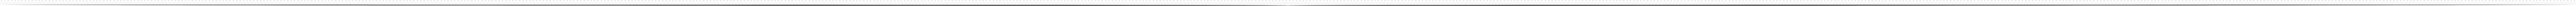

In [5]:
# So we've managed to slow things down ~200 times, just by picking bad chunks. Why? Lets look at a dask graph for a slightly 
# less complicated graph
less_badly_chunked = datastore.search(
    start_date='1950-01-01, 00:00:00',variable='temp'
).to_dask(
    xarray_open_kwargs={
        'chunks' : {
            'time' : 1,
            'st_ocean' : 75,
            'xt_ocean' : 200,
            'yt_ocean' : 200,
        },
        'decode_timedelta': False
    }
)
dask.visualize(less_badly_chunked)

This graph is so big we can't even see it - it's the smudgy line above.

___

## A side note: rechunking after loading

The warnings above suggest rechunking after loading.
Now we know about task graphs, lets see what rechunking after loading *actually does*. We'll take our 12 chunk computation, and turn it into one big chunk.

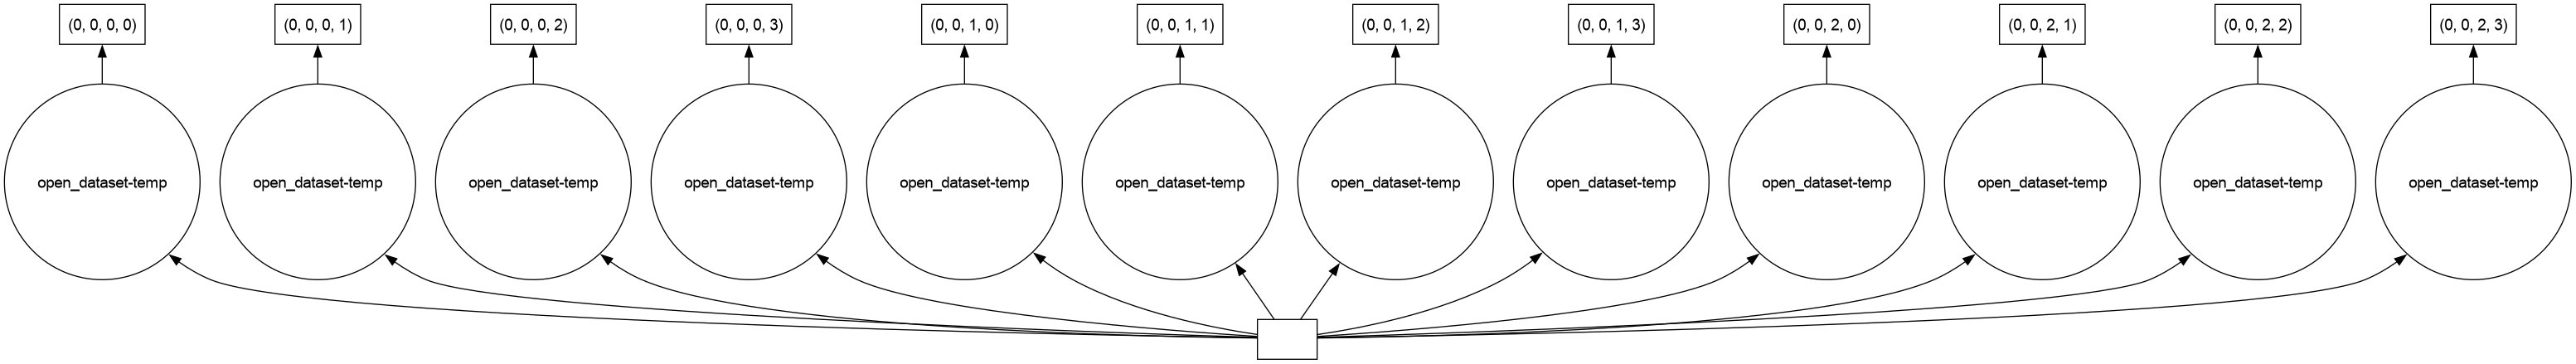

In [6]:
dask.visualize(twelve_chunks)

In [7]:
twelve_chunks.chunk(chunks={
            'time' : -1,
            'st_ocean' : -1,
            'xt_ocean' : -1,
            'yt_ocean' : -1,
        })

<xarray.Dataset> Size: 9GB
Dimensions:   (time: 3, st_ocean: 75, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 24B 1950-01-16 12:00:00 ... 1950-03-16 12:00:00
Data variables:
    temp      (time, st_ocean, yt_ocean, xt_ocean) float32 9GB dask.array<chunksize=(3, 75, 2700, 3600), meta=np.ndarray>
Attributes: (12/19)
    filename:                                 ocean.nc
    title:                                    ACCESS-OM2-01
    grid_type:                                mosaic
    grid_tile:                                1
    intake_esm_vars:                          ['temp']
    intake_esm_attrs:filename:                ocean.nc
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,sea_water_po...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,,,,,,,,,,time: mean,ti...
    intake_esm_attrs:variable_units:          degrees_E,degrees_N,meters,mete...
    intake_esm_attrs:realm:                   ocean
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   ocean.1mon

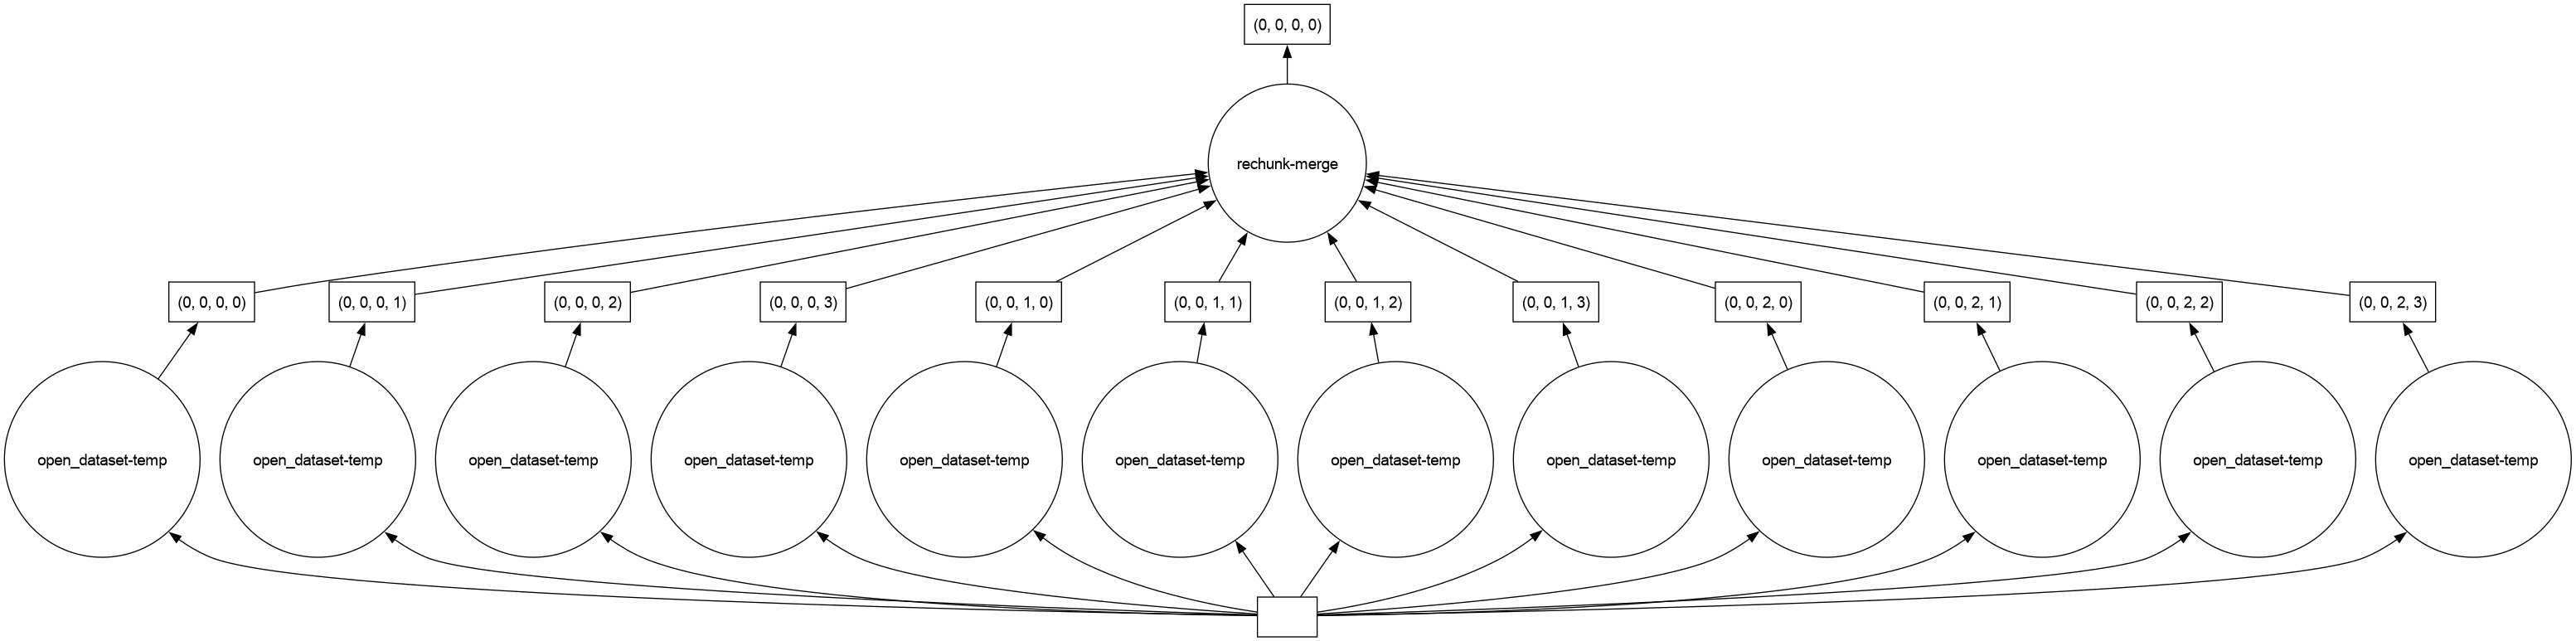

In [8]:
dask.visualize(twelve_chunks.chunk(chunks={
            'time' : -1,
            'st_ocean' : -1,
            'xt_ocean' : -1,
            'yt_ocean' : -1,
        }))

We didn't actually make our computation any simpler - we just added another, explicit layer, where we merge our chunks back together.

___

### So setting bad chunks can make a big task graph - and this can make things slow.

- So does a big task graph mean your computation is badly organised?

Well - yes and no.

- We need the task graph, because it splits jobs up into manageable chunks of memory.
- The limit of making the task graph smaller is not using Dask - and then we know for sure we'll run out of memory.
- So we want to make the task grapher smaller, but not so small that we run out of memory.

If you can make the task graph smaller without running out of memory, then your computation is likely to go faster. With that said - some computations *are just complicated, or can't be worked out in small chunks* - and that means we can't avoid a big task graph.
The computation below is a simple example of this

In [26]:
# I don't know why anyone would ever do this operation - but it very quickly blows 
# up our task graph for 3 to 32 layers.
twelve_chunks.rolling(yt_ocean=10, xt_ocean=10).mean()

<xarray.Dataset> Size: 9GB
Dimensions:   (xt_ocean: 3600, yt_ocean: 2700, st_ocean: 75, time: 3)
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 24B 1950-01-16 12:00:00 ... 1950-03-16 12:00:00
Data variables:
    temp      (time, st_ocean, yt_ocean, xt_ocean) float32 9GB dask.array<chunksize=(1, 3, 909, 909), meta=np.ndarray>
Attributes: (12/19)
    filename:                                 ocean.nc
    title:                                    ACCESS-OM2-01
    grid_type:                                mosaic
    grid_tile:                                1
    intake_esm_vars:                          ['temp']
    intake_esm_attrs:filename:                ocean.nc
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,sea_water_po...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,,,,,,,,,,time: mean,ti...
    intake_esm_attrs:variable_units:          degrees_E,degrees_N,meters,mete...
    intake_esm_attrs:realm:                   ocean
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   ocean.1mon

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.057685 to fit


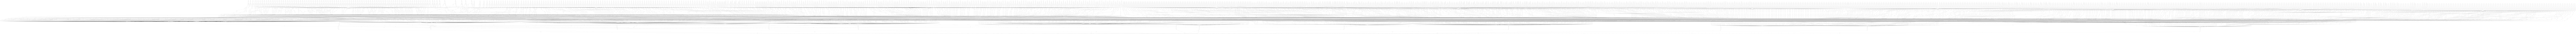

In [27]:
# This makes such a large graph that visualizing only produces the smudge below - and it takes 20 minutes!
dask.visualize(twelve_chunks.rolling(yt_ocean=10, xt_ocean=10).mean())

Trying to speed up your computation using the dask task graph is probably the most powerful tool you have available, in theory - it contains *all* the information. However, in practice, it's generally too much information to really do much with. 